# NetworkX Sumerian Network Tutorial
Authors: Colman Bouton, Niek Velhuis, Yashila Bordag, Adam Anderson

## Introduction

In this demonstration, we will use NetworkX to help explore a small administrative archive of cuneiform tablets from the ancient Sumerian site of Puzrish-Dagan, modern Drehem, Iraq. 

This archive contains many records of the production of fine shoes, precious metals, and gems, making it a fascinating subject of study. We are left with several questions such as why does this small collection of 300 texts exist among thousands of administrative records? 

To help answer this question, we will use network analysis in order to map the relationships between the actors of this small archive, and visualize the social network to find the leaders and their cliques in the archive.

## Dataset

This notebook begins with a prescraped dataset which was constructed as follows. First, the tablets were read and digitized, and then lemmatized in [Oracc](http://oracc.org/epsd2/admin/ur3) data base. We then took the ORACC data and used rule based NLP to find the actors in each transaction which we then used to construct our graph. Visually, we can understand this as follows:

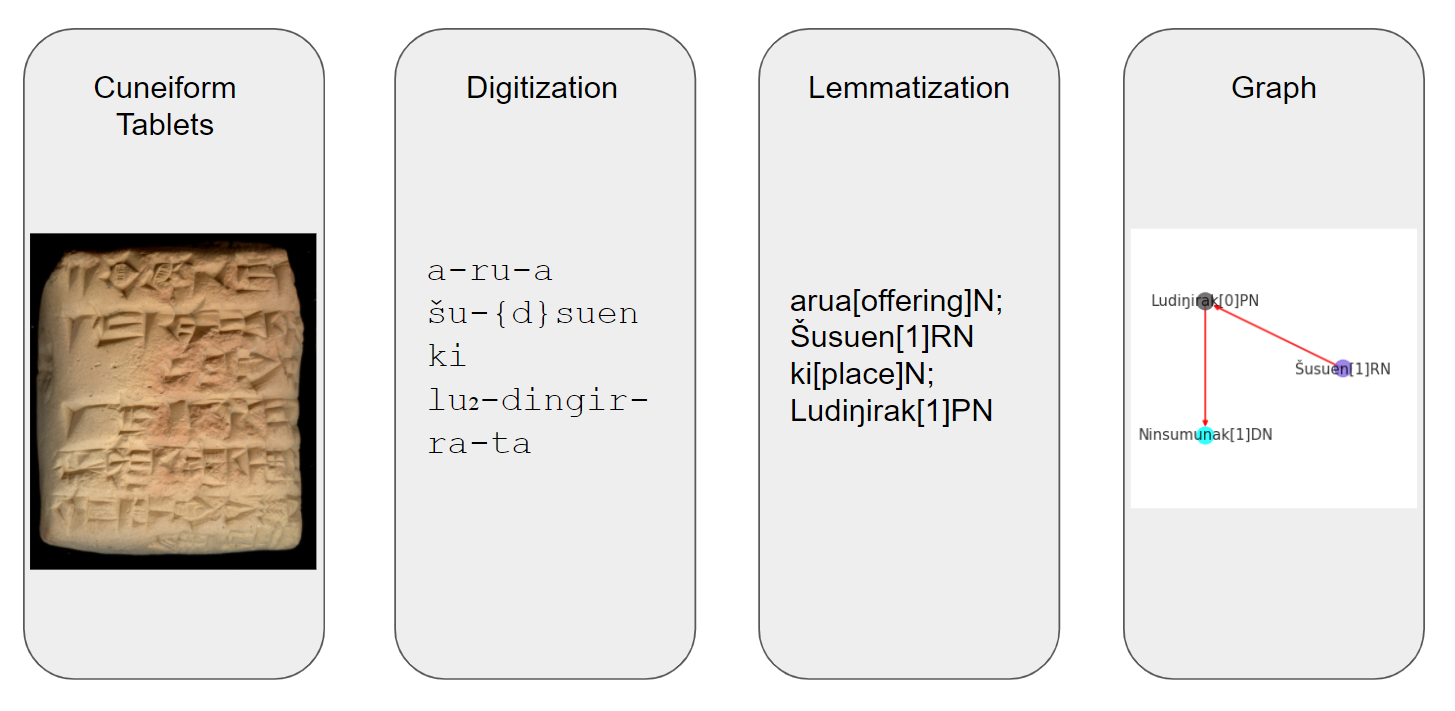

### Tablet Data

In this notebook, we will be computationally examining text from the tablets of the royal archive of Puzriš-Dagan, from approximately 2060-2000 BCE. The tablets were looted from Iraq and sold on the black-market, making their original archaeological context and the original arrangement of the tablets very difficult to ascertain. Therefore, the only way we can really understand the tablets as a set is to analyze the text which they contain - fortunately for us, this is quite a bit of text. There are approximately 15,000 tablets from this archive found world-wide with new tablets regularly resurfacing. Most of the tablets deal with livestock, but a select few (ca. 300) fall into what we call the Treasure and Shoe archive, which we will be analyzing here. 

### ORACC

For this demonstration, we will use lemmatized data from the Open Richly Annotated Cuneiform Corpus ([ORACC](http://oracc.org)) dataset. This lemmatization was performed by scholars in the field of Assyriology, and ORACC provides a standard across all texts and text types for transliteration and lemmatization, using the unique text id numbers assigned by the Cuneiform Digital Library Initiative *[CDLI](http://cdli.ucla.edu)), making the data quite regular. The dataset can be downloaded in a JSON format through an API hosted on the ORACC website, and accompanying the lemmatized data is metadata about the tablets. 

## Node and Edge Harvesting

We use a rule-based generator to scrape the edges and nodes which we stored in a dataframe. A more detailed view of how the node and edges are created can be found in the following notebook: 

https://github.com/admndrsn/NetworkX-graphs/blob/main/NetworkX%20Tutorial%20Data%20Acquisition.ipynb. 

We run the notebook in Google colab, though it can be reconfigured to run locally as well.

## Overview

This notebook will use NetworkX to analyze the scraped nodes and edges we derived from the ORACC dataset. By the end of this notebook, you should have a pretty good overview of how we use NetowrkX in our network analysis process and how network analysis can be used in NLP and with analyzing social networks.

This notebook's basic structure is:
* Initial Setup
* Visualization
    * Defining Helper Functions
    * Visualizing the Network
* Analysis

# Initial Setup

In this section we will import the appropriate libraries for manipulating and analyzing our data. We will also import the data from our Github repository and briefly examine it's structure.

## Import
We then import numpy and the Pandas library, as the tables of edges and nodes are stored as Pandas DataFrames.

In [1]:
import numpy as np
import pandas as pd

## Data
Next, we will download the pickled DataFrames from our GitHub repository containing the data for the edges and nodes of our graph.

In [2]:
edges_frame = pd.read_pickle('https://github.com/admndrsn/NetworkX-graphs/raw/main/edges_frame.p')
nodes_frame = pd.read_pickle('https://github.com/admndrsn/NetworkX-graphs/raw/main/nodes_frame.p')

Let's take a look at what these two tables look like. For starters, here is a sample of the edges table:

In [3]:
edges_frame.head(3)

,source,target,edge_type,id_text,weight
0,Abba[]PN,Inanak[]DN,relation,P103121,1
1,Abisimti[]PN,Damu[]DN,transaction,P144477,1
2,Abisimti[]PN,Gunura[]DN,transaction,P144477,1


Here are a few rows and columns from the nodes table:

In [4]:
nodes_frame[['role', 'attribute', 'transliteration', 'translation', 'pos']].head(3)

,role,attribute,transliteration,translation,pos
lemma,,,,,
A.x[00]PN,recipient,x[NA]NA,A.x,00,PN
Abba[]PN,relation,agaʾus[soldier]N,Abba,,PN
Abisimti[]PN,recipient,,Abisimti,,PN


The structure of the node dataframe is a bit more complicated than the edge dataframe.

In this section, we displayed only those fields which will be important later in the tutorial. First, we have the **lemma** field, which is the word we identified as an actor in the text. This field will act as the node label. The **role** field indicates the roles the actor took in transactions, while the **attributes** field identifies other keywords found in conjuction with this lemma.

Lastly, we have the columns **transliteration**, **translation**, and **pos**. These three contain the same information as can be found in the lemma column, but break it up into each of its components for ease-of-access.

# Building Graphs

The nodes and edges tables correspond to the nodes and edges of the graph respectively. Because each edge corresponds with a particular transaction, the edges are directed from the source of the traded good to the target recipient. Here we use NetworkX to encapsulate the data with an easy to use object which we will leverage to create visualizations and perform analysis.

We are now ready to use NetworkX!

In [5]:
import networkx as nx

In this line we input `edges_frame` as the edge list, provide the source and target, add the edge attribute, and specify that it's a directed graph.


In [6]:
G=nx.convert_matrix.from_pandas_edgelist(edges_frame, source = 'source', target = 'target', 
                                         edge_attr = ['id_text', 'weight', 'edge_type'],
                                         create_using = nx.DiGraph())

After creating the graph from the edge list, we still need to populate the graph with the node attribute data, which we can do in bulk using the `set_node_attributes` method. This method takes in a dictionary where the node name is the key and the attribute data are the values.

We can also add attributes to the NetworkX graph by iterating through the graph.

Now that we have a graph which has all the edges, we will add the data from `nodes_frame` as the attributes of nodes in the graph. Then we iterate through the network to find the degree of each node and also set that attribute in the graph.

In [7]:
nx.set_node_attributes(G, nodes_frame.to_dict(orient='index'))
degree = {name : G.degree[name] for name in G.nodes}
nx.set_node_attributes(G, degree, "degree")

There are a variety of ways to access attributes from the NetworkX graph, including by a particular edge or node, or by nodes or edges as a whole. This allows us to algorithmically analyze the graph.

# Drawing Graphs

In this section we will visualize the network to see some of the ways the nodes are relate to each other using a few helper functions.

## Visualization Helper Functions

Here we will define a set of useful helper function to graph the directed graph.

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

This function helps us find the proportional size of the node.

In [9]:
def node_size_calculator(graph, property_name, minSize, maxSize):
  '''Given the graph, the property_name which we will use as a size reference, 
     and the minSze and maxSize, calculate the relative size of the nodes'''
  node_data = graph.nodes.data(data=property_name)
  data_max = max([v for k,v in node_data])
  data_min = min([v for k,v in node_data])
  return {k: int(minSize + v/(data_max-data_min)*(maxSize-minSize)) 
          for k,v in node_data}

There are several things that are key to creating good positioning for a graph visualization using the spring layout. First, we must use an undirected version of the graph for spring calculations. Otherwise, nodes that have a single directed edge leading into them will not be attracted to any other node and simply fly off.

Additionally, unless the user specifies otherwise, we use the degree of the two nodes of an edge to weaken the strength of the spring. Generally, since degree represents the number of visual features around a node, this will produce the best visualisation.

A further consideration to be had is that if the graph is not connected, its components will fly away from each other without bound. Therefore, it is essential for any graph you might be drawing with `spring_layout` that it is connected. We will be addressing this issue in our own graph at a later step.

In [10]:
def spring_position_calculator(graph, weight_property_name = None, 
                               spring_seed = None):

  gcopy = graph.to_undirected()

  if weight_property_name == None:
    weight_property_name = 'degree'
    for node in gcopy.nodes:
      gcopy.nodes[node]['degree'] = gcopy.degree[node]
  
  avg_weight = np.median([v for k,v in gcopy.nodes().data(data = weight_property_name)]) #used for draw weight calculation
  overall_reduce = 1 / gcopy.number_of_nodes()**0.5
  for edge in gcopy.edges:
    #calculate draw_weight for each edge
    gcopy[edge[0]][edge[1]]['draw_weight'] = overall_reduce * avg_weight * gcopy[edge[0]][edge[1]]['weight'] / (min(gcopy.nodes[edge[0]][weight_property_name], gcopy.nodes[edge[1]][weight_property_name]) + 0.01 * avg_weight)
  
  pos = nx.spring_layout(gcopy, weight = 'draw_weight', 
                         iterations = 500,seed=spring_seed)
  return pos

Now we can put all this to together and create a function that draws a pretty graph! We will default to using a spring graph, as well as taking in some arguments that will allow us to parameterize the size of the nodes and input which metric we will use to color code the nodes with.

In [11]:
def draw_pretty_graph(graph, minSize, maxSize,
                            size_attr_name, figure, color_attr_name = 'degree',
                            spacing_attr_name = None, label_name = None, pos = None, 
                            label_cutoff = 1, spring_seed = None):
  '''Draw a pretty graph using the graph argument and resize the nodes using the
     minSize and maxSize argments, while coloring the nodes by a determined metric'''
  
  # first, we use our previously defined function to create a dict for the sizes
  node_sizes = node_size_calculator(graph, size_attr_name, minSize, maxSize)

  # then we create the list of values for our colormap
  color_values = list(nx.get_node_attributes(graph, color_attr_name).values())
  v_min = min(color_values)
  v_max = max(color_values)

  # if positions are not specified, calculate them using the previous function
  if pos == None:
    pos = spring_position_calculator(graph, spacing_attr_name)

    # we now position the labels:
    label_pos = {}
    num_labels = int(G.number_of_nodes() * label_cutoff) # calculate number of labels to show
    for node in sorted(node_sizes, key = node_sizes.get, reverse=True)[0:num_labels]:
      # set the label position to be slightly offset from the node position
      label_pos[node] = [pos[node][0], pos[node][1] + 0.03]

  # add a subplot to draw the network in 
  ax = figure.add_subplot(1,1,1)

  # draw nodes and edges
  nx.draw_networkx_nodes(        
          graph,
          pos,
          node_size = [node_sizes[node] for node in graph],
          node_color= color_values,
          alpha = 1,
          cmap= plt.cm.plasma, 
          vmax = v_max,
          vmin = v_min,
          ax=ax)
  nx.draw_networkx_edges(        
          graph,
          pos,
          node_size = [node_sizes[node] for node in graph],
          alpha = 0.5,
          edge_color = 'brown',
          width = 2,
          ax = ax)
  
  # draw labels if provided
  if label_name == None:
    nx.draw_networkx_labels(graph, label_pos, 
                            font_size = 10, font_weight = 'bold', ax = ax)
  elif label_name != False: #if label_name is False, dont't draw labels
    labels = {k:graph.nodes.data(data = label_name)[k] for k in label_pos}
    nx.draw_networkx_labels(graph, label_pos, labels = labels, 
                            font_size = 14, font_weight = 'bold', 
                            font_color = 'black', ax = ax)
    
  # draw the colorbar
  norm = mpl.colors.Normalize(vmin = v_min, vmax = v_max)
  options = {'label' : color_attr_name}
  figure.colorbar(mpl.cm.ScalarMappable(norm, plt.cm.plasma), **options);
  

## Visualizing the Graph

Generally speaking, we found setting the edges to be transparent made the graph easier to read, and that making the graph sufficiently large helped us see the individual nodes.

We also chose to color code the nodes based on an assignable metric, which we defaulted to node degree. This makes it easier to discern which nodes are more important. We added a colorbar as a legend for the metric

In spring graphs, the nodes are set to pull apart from each other and the edges act as springs pulling the nodes together. When the positions are being calculated, the repellant forces and the attractant forces through the springs are added up over a series of iterations until the graph settles into a particular set of positions. In some cases, when there is a large set of data, you might see the nodes clump together, making the nodes difficult to interpret individually.

Here we take the largest connected subgraph and use the `draw_pretty_graph` helper function to draw our network using a spring graph. 

Most of the nodes in our graph are pretty small, meaning they have a pretty low degree, but we see some interesting main actors - Ludiŋirak, PuzurErra,  lugal (the king), Dayyanummisar, AradNanna, Lugalkugzu, etc. These nodes end up at the center of our graph because they are fairly well connected and thus are only pulled apart by less connected nodes.

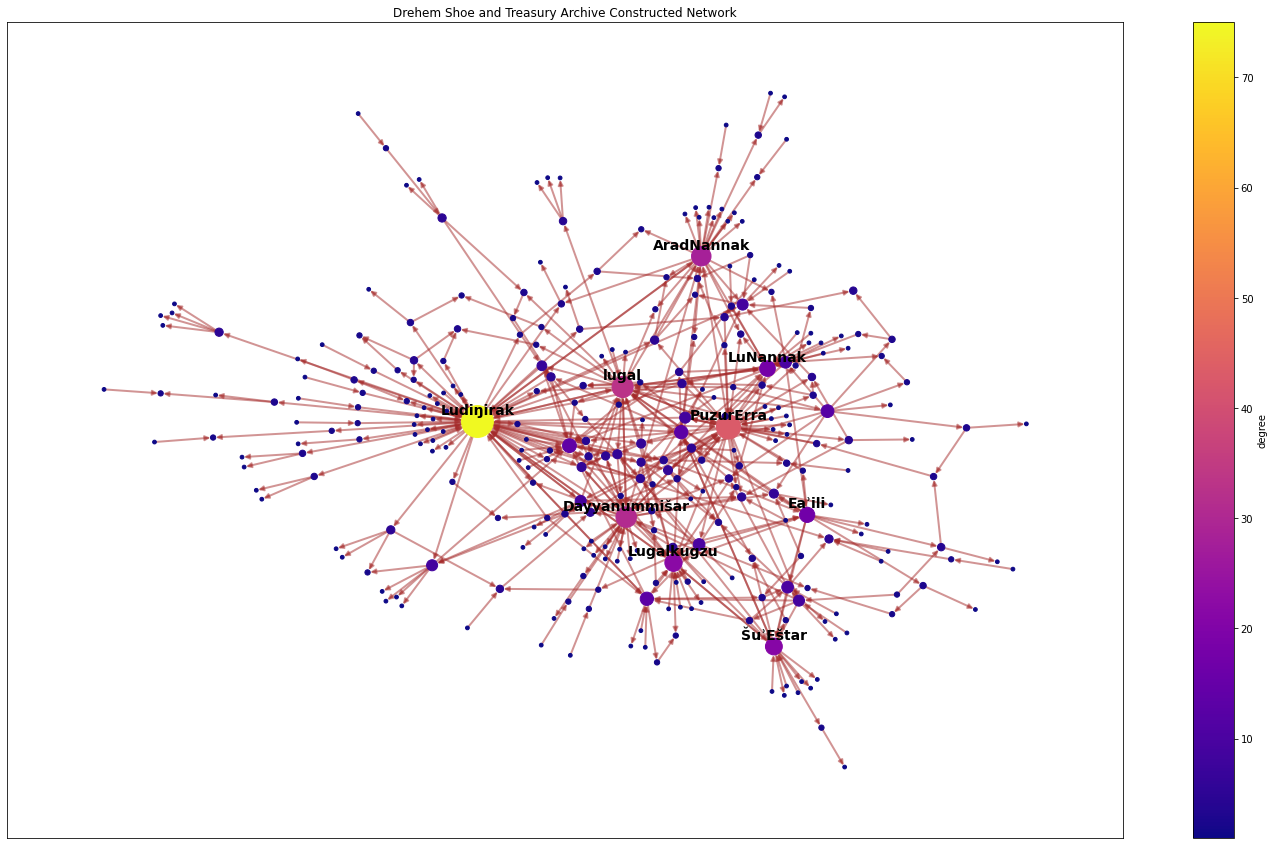

In [12]:
# remove nodes which have no connections to other nodes in the graph
mainc = max(nx.algorithms.components.connected_components(G.to_undirected()), 
            key = len)
I = G.subgraph(mainc).copy()

# draw the graph using draw_pretty_graph helper function
figure = plt.figure(figsize=(25, 15))
draw_pretty_graph(I, 1, 1000, "degree", figure,
                  color_attr_name = 'degree',
                  label_name = 'transliteration', label_cutoff = 0.03);

plt.title('Drehem Shoe and Treasury Archive Constructed Network');

# Analysis

## Centrality Measures

There are many attributes that we can compute for each node in our graph. Specifically, we are interested in conceptualizing the relative importance of particular nodes which can be expressed as the centrality of a node in the graph. 

* The number of connections a node has to other nodes in the graph contributes to its **degree centrality**. 
* The **in degree centrality** refers to the number of incoming connections (where the node is the target), whereas **out degree centrality** refers to the number of outgoing connections (where the node is the source).
* The **betweenness centrality** is based on the number of shortest paths between any two nodes in the graph that go through this node. 
* The **closeness centrality** is related to the sum of the shortest distances from one node to the rest of the nodes.
* The **eigenvector centrality** is a measure that takes into account the centrality of the nodes that the node under consideration connects to. A node that connects to many low-ranking nodes will receive a low **eigenvector centrality** score. A node that connects to a few well-connected nodes will receive a high **eigenvector centrality** score.

**Hub** and **authority**, finally, are interrelated measures that were originally developed for ranking web pages. A node with high hub value points towards multiple nodes with high authority value. A node with high authority value has incoming connections from multiple nodes with high hub  value. Hub and authority are thus defined by each other and the process of computing hub and authority values is an iterative one.

In [13]:
eigenvector = nx.eigenvector_centrality(G)
eigenvector_weighted = nx.eigenvector_centrality(G,weight = 'weight')
eigenvector_undirected = nx.eigenvector_centrality(G.to_undirected(), weight = 'weight')
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
hub, authority = nx.hits(G)

In [14]:
centrality = [eigenvector, eigenvector_weighted, eigenvector_undirected,
              degree_centrality, in_degree_centrality, 
              out_degree_centrality, closeness_centrality, 
              betweenness_centrality, hub, authority]
centrality_labels = ["eigenvector", "eigenvector_weighted", 
                     "eigenvector_undirected", "degree centrality", 
                     "in degree centrality",
                     "out degree centrality", "closeness centrality",
                     "betweenness centrality", "hub", "authority"]

In [15]:
for idx, m in enumerate(centrality):
  nx.set_node_attributes(G, m, name=centrality_labels[idx])

Here we plot a histogram of weighted eigenvector centrality and note that at around 0.07 there is a gap. We will use this information to look at the individuals above 0.07 as the 'influencial' figures. Remember, higher eigenvector centrality indicates connections with other well-connected nodes.

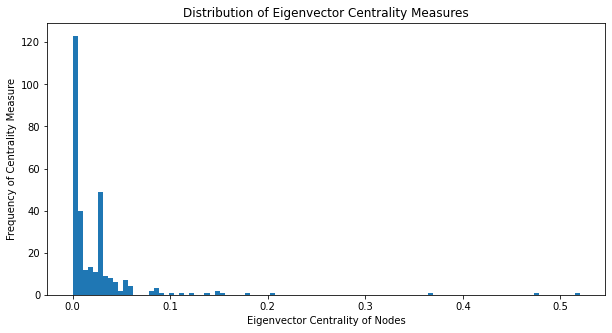

In [16]:
plt.figure(figsize = (10, 5))

hist = plt.hist(eigenvector_undirected.values(), bins = 'stone')
plt.xlabel("Eigenvector Centrality of Nodes")
plt.ylabel("Frequency of Centrality Measure")
plt.title("Distribution of Eigenvector Centrality Measures");

Here, we visualize the subgraph generated by nodes with eigenvector centrality greater than 0.07. We see that this subgraph includes several of the important figures from the graph in the previous section, such as Ludiŋirak, PuzurErra, the lugal, Dayyanummisar, AradNanna, and Lugalkugzu.

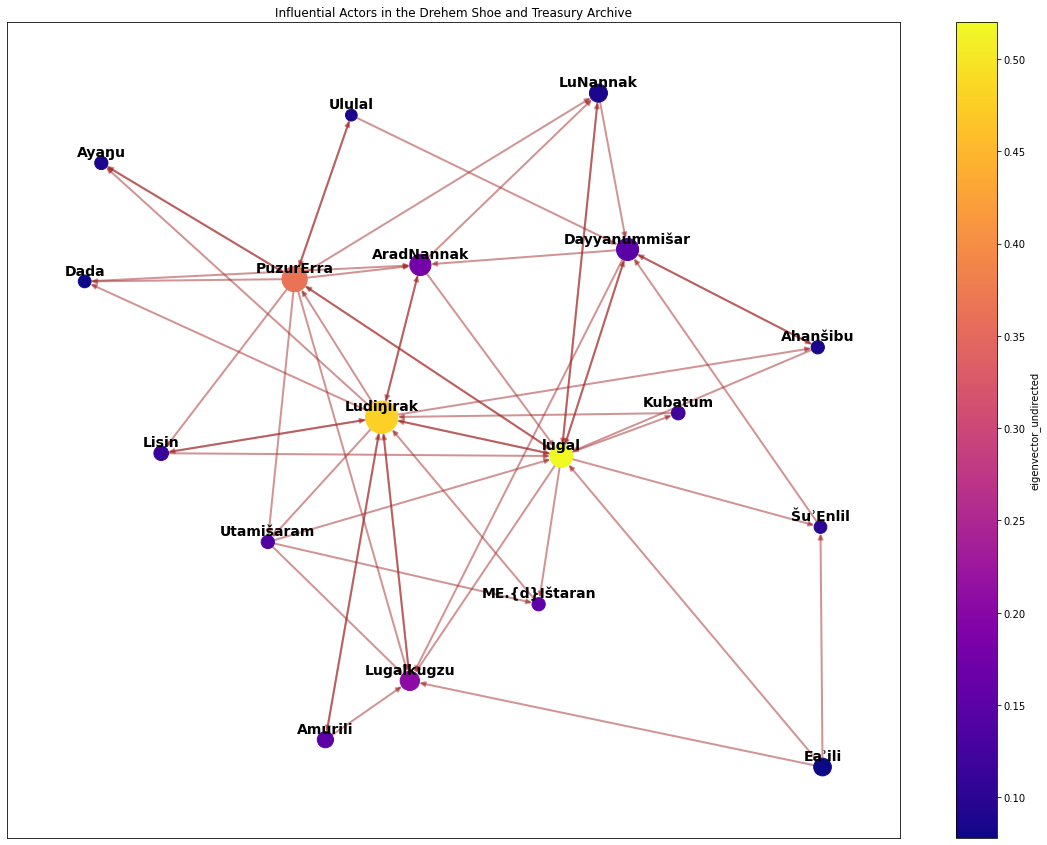

In [17]:
figure = plt.figure(figsize = [20,15])
J = G.subgraph([node for node in G.nodes if G.nodes[node]['eigenvector_undirected'] > 0.07])
draw_pretty_graph(J, 100,1000, 'degree', figure, color_attr_name = 'eigenvector_undirected', label_name = 'transliteration')
plt.title('Influential Actors in the Drehem Shoe and Treasury Archive');